In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '/home/johanna/ICB/annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


In [73]:
n_rounds = 1
data = pd.read_csv('../data/countTable.0.CTCF_r3.tsv.gz', sep='\t', header=None)
data.columns = ['seq'] + [i for i in range(n_rounds+1)]
# data = data.sample(n=1000)
# data.index = range(len(data))
dataset = mb.datasets.SelexDataset(data, n_rounds=n_rounds)
train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)

In [5]:
print(len(dataset))

1000


In [74]:
model = mb.models.DinucSelex(use_dinuc=False, kernels=[0, 14, 12], n_rounds=1).to(device)
l2 = []
optimiser = topti.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimiser = topti.LBFGS(model.parameters())
criterion = mb.tl.PoissonLoss()

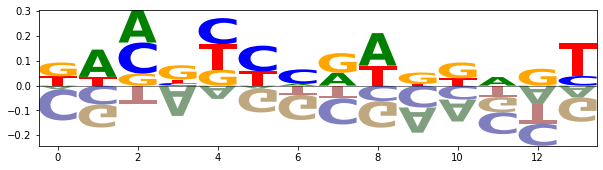

In [75]:
weights = model.conv_mono[1].weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

In [76]:
print(model.log_eta.weight)

Parameter containing:
tensor([[0.],
        [0.]], requires_grad=True)


In [77]:
print(model.log_activity.weight)

Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], requires_grad=True)


In [81]:
print(model.log_eta.weight)

Parameter containing:
tensor([[ 0.2489],
        [-0.2489]], requires_grad=True)


In [82]:
print(model.log_activity.weight)

Parameter containing:
tensor([[-2.7435e-05, -5.0652e-01],
        [-1.1145e-05, -1.7477e-01],
        [-1.1367e-05, -1.5834e-01]], requires_grad=True)


In [58]:
list(model.parameters())[4].grad

tensor([[8.0472e-11, 2.3161e-01],
        [4.6330e-11, 1.0269e-02],
        [4.9000e-11, 1.0093e-02]])

In [78]:
l2 += mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=10, log_each=1)

Epoch:  1, Loss: 0.940
Epoch:  2, Loss: 0.844
Epoch:  3, Loss: 0.843
Epoch:  4, Loss: 0.843
Epoch:  5, Loss: 0.842
Epoch:  6, Loss: 0.842
Epoch:  7, Loss: 0.842
Epoch:  8, Loss: 0.842
Epoch:  9, Loss: 0.842
Epoch: 10, Loss: 0.841


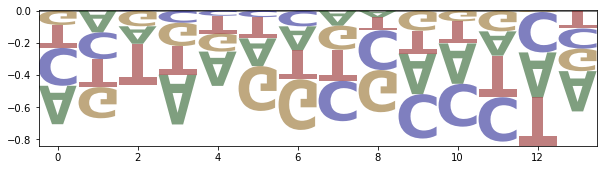

In [79]:
weights = model.conv_mono[1].weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

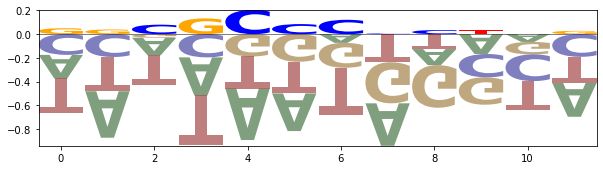

In [80]:
weights = model.conv_mono[2].weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

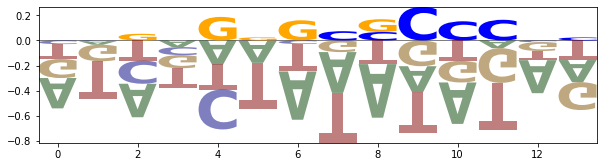

In [82]:
weights = model.conv_mono[1].weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

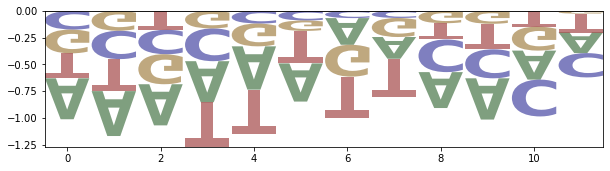

In [83]:
weights = model.conv_mono[2].weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

In [84]:
print(model.log_eta.weight)

Parameter containing:
tensor([[ 0.2947],
        [-0.2382]], requires_grad=True)


In [85]:
print(model.log_activity.weight)

Parameter containing:
tensor([[-4.9551e-07, -2.1618e-01],
        [ 3.6056e-07, -1.0918e+00],
        [-2.0377e-07,  1.2980e+00]], requires_grad=True)


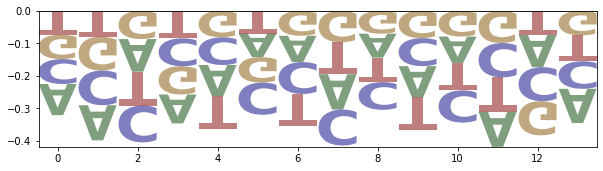

In [42]:
weights = model.conv_mono[1].weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

In [31]:
all_targets, all_outputs = [], []
for i, batch in enumerate(train_test):
    # Get a batch and potentially send it to GPU memory.
    # print(batch.keys())
    # mononuc = batch["mononuc"].type(torch.LongTensor).to(device)
    mononuc = batch['mononuc'].to(device)
    mononuc_rev = batch['mononuc_rev'].to(device)
    dinuc = batch['dinuc'].type(torch.LongTensor).to(device) if 'dinuc' in batch else None
    dinuc_rev = batch['dinuc_rev'].to(device) if 'dinuc_rev' in batch else None
    b = batch['batch'].to(device) if 'batch' in batch else None
    target = batch['target'].to(device) if 'target' in batch else None
    rounds = batch['rounds'].to(device) if 'rounds' in batch else None
    is_count_data = batch['is_count_data'] if 'is_count_data' in batch else None
    seqlen = batch['seqlen'] if 'seqlen' in batch else None

    inputs = (mononuc, mononuc_rev, dinuc, dinuc_rev, b, seqlen, torch.sum(rounds, axis=1))
    outputs = model(inputs)  # Forward pass through the network.
    all_targets.append(rounds.squeeze().cpu().detach().numpy())
    all_outputs.append(outputs.squeeze().cpu().detach().numpy())

In [32]:
all_outputs

[array([0.57917863, 0.42082137], dtype=float32),
 array([0.5885679 , 0.41143203], dtype=float32),
 array([0.5913879 , 0.40861204], dtype=float32),
 array([0.5860879 , 0.41391218], dtype=float32),
 array([0.5844755 , 0.41552445], dtype=float32),
 array([0.58243203, 0.4175679 ], dtype=float32),
 array([0.5903414, 0.4096586], dtype=float32),
 array([0.5893603, 0.4106397], dtype=float32),
 array([0.5970563, 0.4029437], dtype=float32),
 array([0.56510484, 0.43489516], dtype=float32),
 array([0.5803156 , 0.41968438], dtype=float32),
 array([0.5840377 , 0.41596222], dtype=float32),
 array([0.58324796, 0.41675204], dtype=float32),
 array([0.57932866, 0.4206713 ], dtype=float32),
 array([0.57440937, 0.42559066], dtype=float32),
 array([0.5694007 , 0.43059927], dtype=float32),
 array([0.592965, 0.407035], dtype=float32),
 array([0.5842929, 0.4157071], dtype=float32),
 array([0.5880885 , 0.41191152], dtype=float32),
 array([0.59194404, 0.40805602], dtype=float32),
 array([0.5872956 , 0.41270438],

In [102]:
all_targets, all_outputs = [], []
for i, batch in enumerate(train_test):
    # Get a batch and potentially send it to GPU memory.
    # print(batch.keys())
    # mononuc = batch["mononuc"].type(torch.LongTensor).to(device)
    mononuc = batch['mononuc'].to(device)
    mononuc_rev = batch['mononuc_rev'].to(device)
    dinuc = batch['dinuc'].type(torch.LongTensor).to(device) if 'dinuc' in batch else None
    dinuc_rev = batch['dinuc_rev'].to(device) if 'dinuc_rev' in batch else None
    b = batch['batch'].to(device) if 'batch' in batch else None
    target = batch['target'].to(device) if 'target' in batch else None
    rounds = batch['rounds'].to(device) if 'rounds' in batch else None
    is_count_data = batch['is_count_data'] if 'is_count_data' in batch else None
    seqlen = batch['seqlen'] if 'seqlen' in batch else None

    inputs = (mononuc, mononuc_rev, dinuc, dinuc_rev, b, seqlen, torch.sum(rounds, axis=1))
    outputs = model(inputs)  # Forward pass through the network.
    all_targets.append(rounds.squeeze().cpu().detach().numpy())
    all_outputs.append(outputs.squeeze().cpu().detach().numpy())

In [ ]:
all_outputs